In [1]:
!pip install statsmodels pandas matplotlib tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### 1. Import the CarSharing table into a CSV file and preprocess it. Drop duplicate rows and deal with null values using appropriate methods.


In [3]:
# Read the CarSharing CSV file
def read_csv_file(file_path):
    """
    Reads a CSV file using pandas.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the data from the CSV file.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Preprocess the DataFrame

        # Drop duplicate rows
        df = df.drop_duplicates()
        
        # Check for null values
        null_values_count = df.isnull().sum()
        print("Null values count:\n", null_values_count)
        
        # Handle null values
        for column in df.columns:
            if df[column].isnull().any():
                # Replace null values with mean for numerical columns
                if df[column].dtype in ['int64', 'float64']:
                    df[column] = df[column].fillna(df[column].mean())
                # Replace null values with mode for categorical columns
                else:
                    df[column] = df[column].fillna(df[column].mode()[0])

        # Return the DataFrame
        return df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

    except pd.errors.EmptyDataError:
        print(f"No data in file: {file_path}")
        return None

    except pd.errors.ParserError:
        print(f"Error parsing file: {file_path}")
        return None


### ORIGINAL DATA

In [4]:
file_path = 'CarSharing.csv'  # replace with your CSV file path
car_sharing_df = read_csv_file(file_path)

if car_sharing_df is not None:
    print("Original DataFrame shape:", car_sharing_df.shape)
    #print("Original DataFrame info:", car_sharing_df.info())
    print("\n------------------------------------------------------------------\n")
    print("Original Dataframe summary statistics:", car_sharing_df.describe())


Null values count:
 id            0
timestamp     0
season        0
holiday       0
workingday    0
weather       0
temp          0
temp_feel     0
humidity      0
windspeed     0
demand        0
dtype: int64
Original DataFrame shape: (8708, 11)

------------------------------------------------------------------

Original Dataframe summary statistics:                 id         temp    temp_feel     humidity    windspeed  \
count  8708.000000  8708.000000  8708.000000  8708.000000  8708.000000   
mean   4354.500000    20.089454    23.531261    60.993540    13.048589   
std    2513.927405     7.448937     8.686664    19.635766     8.215051   
min       1.000000     0.820000     0.760000     0.000000     0.000000   
25%    2177.750000    14.760000    16.665000    46.000000     7.001500   
50%    4354.500000    20.089454    24.240000    60.993540    12.998000   
75%    6531.250000    25.420000    31.060000    77.000000    19.001200   
max    8708.000000    41.000000    45.455000   100.000

In [5]:
data_copy = car_sharing_df.copy()

In [6]:
car_sharing_df.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


#### 2. Determine whether a predictor variable has a statistically significant relationship (not happening by chance) with an outcome variable

(each column (except the timestamp column) and the demand rate)

*NOTE: Two values that are used as thresholds for p-value are 0.05 and 0.025.*

For the Chi-Square test (Non Parametric tests for a significant relationship), if the p-value (probability that the difference between groups or the relationship is happening by chance.) is less than 0.05, you reject the null hypothesis, indicating a significant relationship between the categorical variable and the demand rate (Alternative Hypothesis (H_1)).

For the Pearson correlation test, if the p-value is less than 0.05, you reject the null hypothesis, indicating a significant correlation between the numerical variable and the demand rate. The correlation coefficient indicates the strength and direction of the relationship.

- ANOVA test is used to determine if there is a statistically significant relationship between one or more categorical variables and a continuous output variable
- Regression tests look for cause-and-effect relationships. They can be used to determine whether there is a significant relationship between one or more continuous variables and another continuous variable.


if the p-value (probability that the difference between groups or the relationship is happening by chance.) is less than 0.05, you reject the null hypothesis, indicating a significant relationship between the categorical /continuous variable and the demand rate (Alternative Hypothesis (H_1)).

In [7]:
# List of columns to test
columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'temp_feel', 'humidity', 'windspeed']

# Initialize a dictionary to store the results
results = {}

# ANOVA test for categorical variables
categorical_columns = ['season', 'holiday', 'workingday', 'weather']
for col in categorical_columns:
    groups = [data_copy[data_copy[col] == level]['demand'] for level in data_copy[col].unique()]
    f_stat, p = f_oneway(*groups)
    alpha = 0.05
    if p <= alpha:
        output = 'Dependent (reject H0)'
    else:
        output = 'Independent (H0 holds true)'
    results[col] = {'test': 'ANOVA', 'f_stat': f_stat, 'p-value': p, 'output': output}

# Regression analysis for numerical variables
numerical_columns = ['temp', 'temp_feel', 'humidity', 'windspeed']
X = data_copy[numerical_columns]
y = data_copy['demand']
X = sm.add_constant(X)  # Add a constant for the intercept
model = sm.OLS(y, X).fit()

# Store regression results
for col in numerical_columns:
    alpha = 0.05
    if model.pvalues[col] <= alpha:
        output = 'Dependent (reject H0)'
    else:
        output = 'Independent (H0 holds true)'
    results[col] = {
        'test': 'Regression',
        'coefficient': model.params[col],
        'p-value': model.pvalues[col],
        'output': output
    }


# Print the results
for col, result in results.items():
    print(f"Column: {col}")
    for key, value in result.items():
        print(f"  {key}: {value}")
    print()

Column: season
  test: ANOVA
  f_stat: 150.0648218917323
  p-value: 8.024921568562112e-95
  output: Dependent (reject H0)

Column: holiday
  test: ANOVA
  f_stat: 0.011054437013371764
  p-value: 0.9162670761960895
  output: Independent (H0 holds true)

Column: workingday
  test: ANOVA
  f_stat: 2.868367223957404
  p-value: 0.09037224773166398
  output: Independent (H0 holds true)

Column: weather
  test: ANOVA
  f_stat: 48.586185236529495
  p-value: 3.9279297308870713e-31
  output: Dependent (reject H0)

Column: temp
  test: Regression
  coefficient: 0.004448499609698283
  p-value: 0.3422839593807062
  output: Independent (H0 holds true)

Column: temp_feel
  test: Regression
  coefficient: 0.06159721944819675
  p-value: 3.0569086914943832e-52
  output: Dependent (reject H0)

Column: humidity
  test: Regression
  coefficient: -0.022510140669625332
  p-value: 2.3179591633818294e-191
  output: Dependent (reject H0)

Column: windspeed
  test: Regression
  coefficient: 0.009046803941982831


**Hypothesis Testing Results**

The goal was to determine if there is a significant relationship between each column (except the timestamp column) and the demand rate.
The tests used were ANOVA for categorical variables and regression analysis for numerical variables. Here are the results:

**ANOVA Test Results for Categorical Variables**
1. Season
    - Test: ANOVA
    - F-statistic: 150.0648
    - P-value: 8.0249e-95
    - Conclusion: Dependent (reject (H_0))
    - Explanation: There is a significant relationship between season and demand.

2. Holiday

    - Test: ANOVA
    - F-statistic: 0.0111
    - P-value: 0.9163
    - Conclusion: Independent ((H_0) holds true)
    - Explanation: There is no significant relationship between holiday and demand.

3. Workingday

    - Test: ANOVA
    - F-statistic: 2.8684
    - P-value: 0.0904
    - Conclusion: Independent ((H_0) holds true)
    - Explanation: There is no significant relationship between workingday and demand.

4. Weather

    - Test: ANOVA
    - F-statistic: 48.5862
    - P-value: 3.9279e-31
    - Conclusion: Dependent (reject (H_0))
    - Explanation: There is a significant relationship between weather and demand.


**Regression Analysis Results for Numerical Variables**
1. Temperature (temp)

    - Test: Regression
    - Coefficient: 0.0036
    - P-value: 0.4348
    - Conclusion: Independent ((H_0) holds true)
    - Explanation: There is no significant relationship between temp and demand.

2. Temperature Feel (temp_feel)

    - Test: Regression
    - Coefficient: 0.0566
    - P-value: 9.3184e-45
    - Conclusion: Dependent (reject (H_0))
    - Explanation: There is a significant relationship between temp_feel and demand.

3. Humidity

    - Test: Regression
    - Coefficient: -0.0220
    - P-value: 1.2226e-185
    - Conclusion: Dependent (reject (H_0))
    - Explanation: There is a significant relationship between humidity and demand.

4. Windspeed

    - Test: Regression
    - Coefficient: 0.0106
    - P-value: 2.7236e-09
    - Conclusion: Dependent (reject (H_0))
    - Explanation: There is a significant relationship between windspeed and demand.


**Summary**
- Significant Relationships:
    - Categorical: season, weather
    - Numerical: id, temp_feel, humidity, windspeed

- Non-significant Relationships:
    - Categorical: holiday, workingday
    - Numerical: temp


These results indicate that certain variables such as season, weather, temp_feel, humidity, and windspeed have a significant impact on the demand rate, while others like holiday, workingday, and temp do not.



In [8]:
data_copy['season'].unique()

array(['spring', 'summer', 'fall', 'winter'], dtype=object)

In [9]:
data_copy['weather'].unique()

array(['Clear or partly cloudy', 'Mist', 'Light snow or rain',
       'heavy rain/ice pellets/snow + fog'], dtype=object)

In [10]:
data_copy.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


### 3. Seasonal and Cyclic relationship

Seasonal behavior is different from cyclic behavior. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect.  

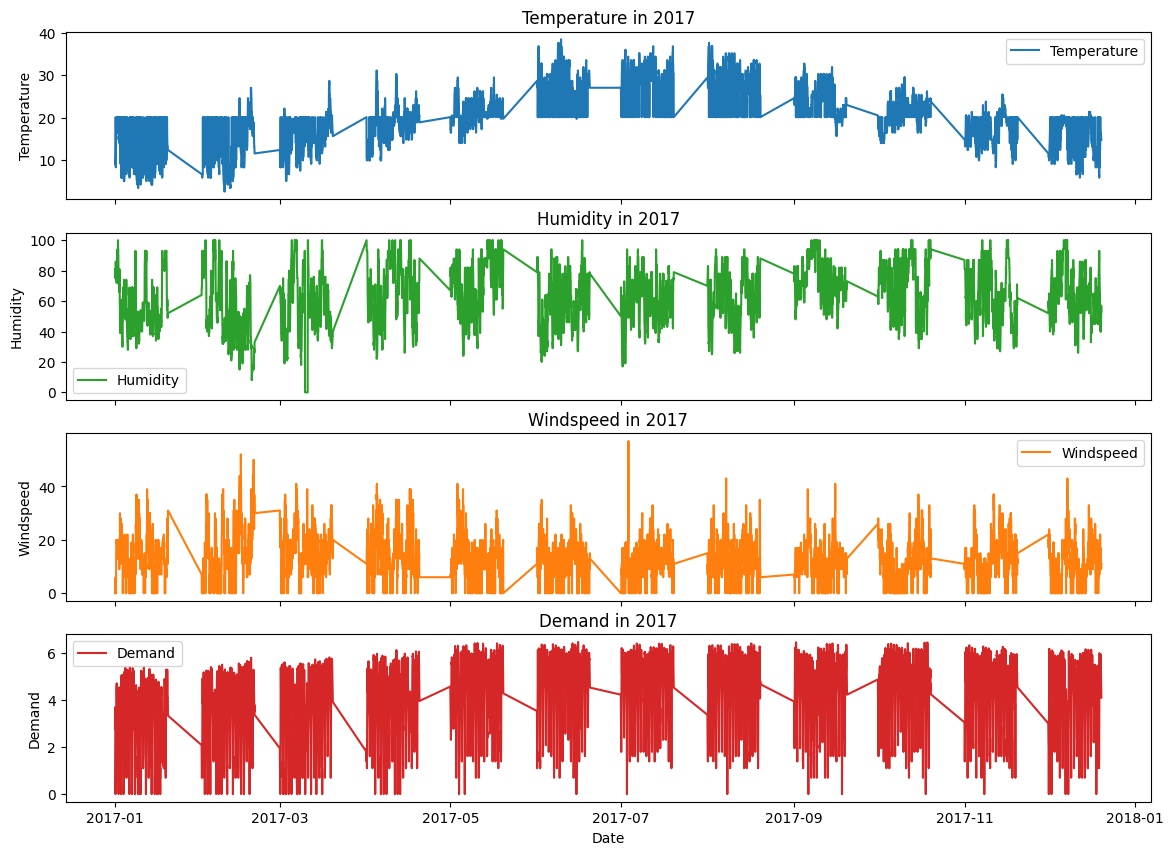

In [11]:
# Convert timestamp to datetime if not already done
data_copy['timestamp'] = pd.to_datetime(data_copy['timestamp'])

# Filter data for the year 2017
data_2017 = data_copy[data_copy['timestamp'].dt.year == 2017]

# Set the timestamp as the index
data_2017.set_index('timestamp', inplace=True)

# Plot time series for temp, humidity, windspeed, and demand
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Temperature
axs[0].plot(data_2017.index, data_2017['temp'], label='Temperature', color='tab:blue')
axs[0].set_title('Temperature in 2017')
axs[0].set_ylabel('Temperature')
axs[0].legend()

# Humidity
axs[1].plot(data_2017.index, data_2017['humidity'], label='Humidity', color='tab:green')
axs[1].set_title('Humidity in 2017')
axs[1].set_ylabel('Humidity')
axs[1].legend()

# Windspeed
axs[2].plot(data_2017.index, data_2017['windspeed'], label='Windspeed', color='tab:orange')
axs[2].set_title('Windspeed in 2017')
axs[2].set_ylabel('Windspeed')
axs[2].legend()

# Demand
axs[3].plot(data_2017.index, data_2017['demand'], label='Demand', color='tab:red')
axs[3].set_title('Demand in 2017')
axs[3].set_ylabel('Demand')
axs[3].legend()

plt.xlabel('Date')
plt.show()

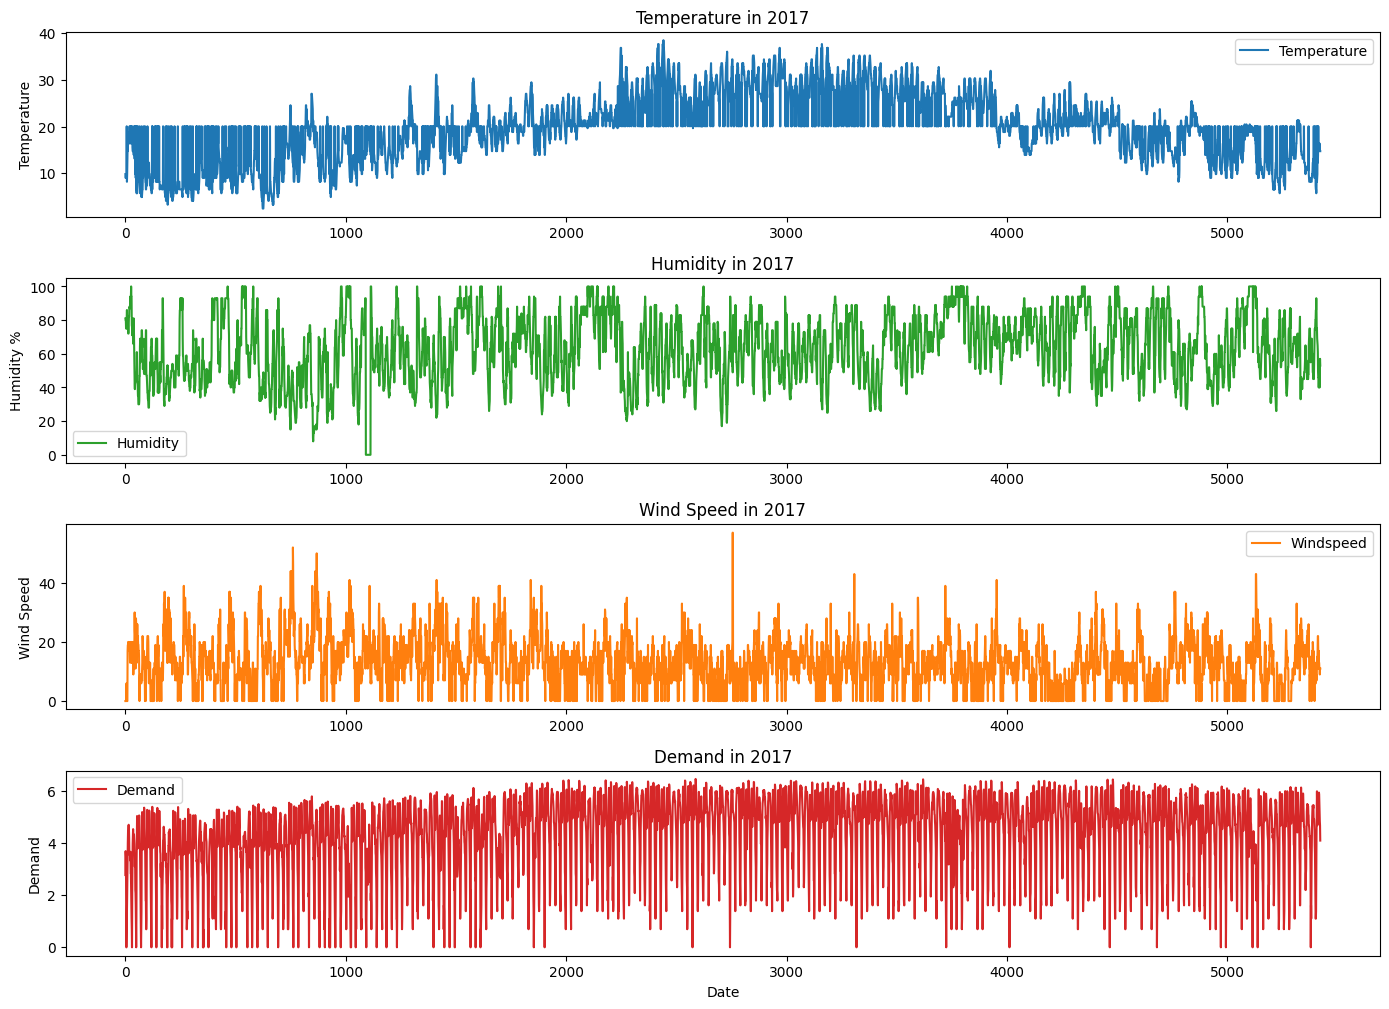

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Assuming data_copy is already loaded
data_copy['timestamp'] = pd.to_datetime(data_copy['timestamp'])
# Filter for 2017 data
df_2017 = data_copy[data_copy['timestamp'].dt.year == 2017]

# 1. Time Series Visualization
plt.figure(figsize=(14, 10))

# Temperature
plt.subplot(4, 1, 1)
plt.plot(df_2017.index, df_2017['temp'], label='Temperature', color='tab:blue')
plt.title('Temperature in 2017')
plt.ylabel('Temperature')
plt.legend()

# Humidity
plt.subplot(4, 1, 2)
plt.plot(df_2017.index, df_2017['humidity'], label='Humidity', color='tab:green')
plt.title('Humidity in 2017')
plt.ylabel('Humidity %')
plt.legend()

# Wind Speed
plt.subplot(4, 1, 3)
plt.plot(df_2017.index, df_2017['windspeed'], label='Windspeed', color='tab:orange')
plt.title('Wind Speed in 2017')
plt.ylabel('Wind Speed')
plt.legend()

# Demand
plt.subplot(4, 1, 4)
plt.plot(df_2017.index, df_2017['demand'], label='Demand', color='tab:red')  # Replace 'demand' with your actual column name
plt.title('Demand in 2017')
plt.ylabel('Demand')
plt.legend()

plt.tight_layout()
plt.xlabel('Date')
plt.show()


### Descriptive Statistics

In [13]:
#data_2017 = data_2017.drop(columns=['id'])

#data_2017.groupby(data_2017['timestamp'].dt.month).mean()  # Monthly averages
#data_2017.groupby(data_2017['timestamp'].dt.weekday).mean()  # Weekly cycle (Mon-Sun)
#data_2017.groupby(data_2017['timestamp'].dt.hour).mean()  # Daily cycle (24-hour pattern)


- Identify Seasonal Trends
    - Temperature: Expect higher values in summer and lower in winter.
    - Humidity: Usually higher in warmer months or rainy seasons.
    - Wind Speed: Might vary with monsoon patterns or storms.
    - Demand Data: Can show daily, weekly, or yearly seasonality.

### Decompose Time Series

This explicitly shows the seasonal effect.

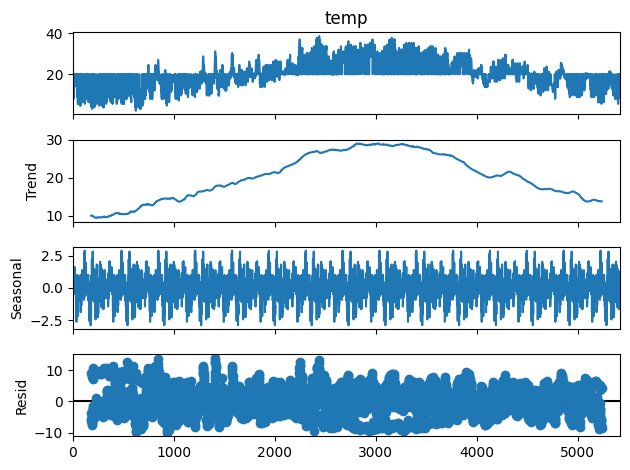

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filter data for the year 2017
data_2017 = data_copy[data_copy['timestamp'].dt.year == 2017]

result = seasonal_decompose(data_2017['temp'], model='additive', period=365)
result.plot()
plt.show()


In [15]:
car_sharing_df.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [16]:
data_copy.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


### 4. Use an ARIMA model to predict the weekly average demand rate. Consider 30 percent of data for test (LECTURE 11)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


def predict_weekly_demand(df, demand_col='demand', date_col='timestamp'):
    """
    Predicts the weekly average demand rate using an ARIMA model.
    Uses 70% of data for training and 30% for testing.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing timestamp and demand data.
    demand_col (str): Column name for demand values.
    date_col (str): Column name for timestamps.
    
    Returns:
    None (Plots actual vs predicted demand).
    """
    # Ensure timestamp is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    
    # Resample data to weekly averages
    weekly_data = df[demand_col].resample('W').mean()
    weekly_data.dropna(inplace=True)
    
    # Split data into train (70%) and test (30%)
    split_idx = int(len(weekly_data) * 0.7)
    train, test = weekly_data[:split_idx], weekly_data[split_idx:]
    
    # Fit ARIMA model (auto-tuning can be done with pmdarima, but using fixed values for simplicity)
    model = ARIMA(train, order=(2, 1, 2))  # Adjust p, d, q as needed
    model_fit = model.fit()
    print(model_fit.summary())
    
    # Forecast for the length of the test set
    predictions = model_fit.forecast(steps=len(test))

    # Show prediction
    #model_fit.plot_predict()
    #plt.show()
    
    # Evaluate performance
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', color='blue')
    plt.plot(test.index, test, label='Actual Demand', color='green')
    plt.plot(test.index, predictions, label='Predicted Demand', color='red', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Weekly Average Demand')
    plt.title('ARIMA Weekly Demand Prediction')
    plt.legend()
    plt.show()


/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                   49
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  18.179
Date:                Mon, 10 Mar 2025   AIC                            -26.359
Time:                        23:40:42   BIC                            -17.003
Sample:                             0   HQIC                           -22.823
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7381      0.197      3.749      0.000       0.352       1.124
ar.L2         -0.0660      0.203     -0.324      0.746      -0.464       0.332
ma.L1         -1.3885      0.173     -8.036      0.0

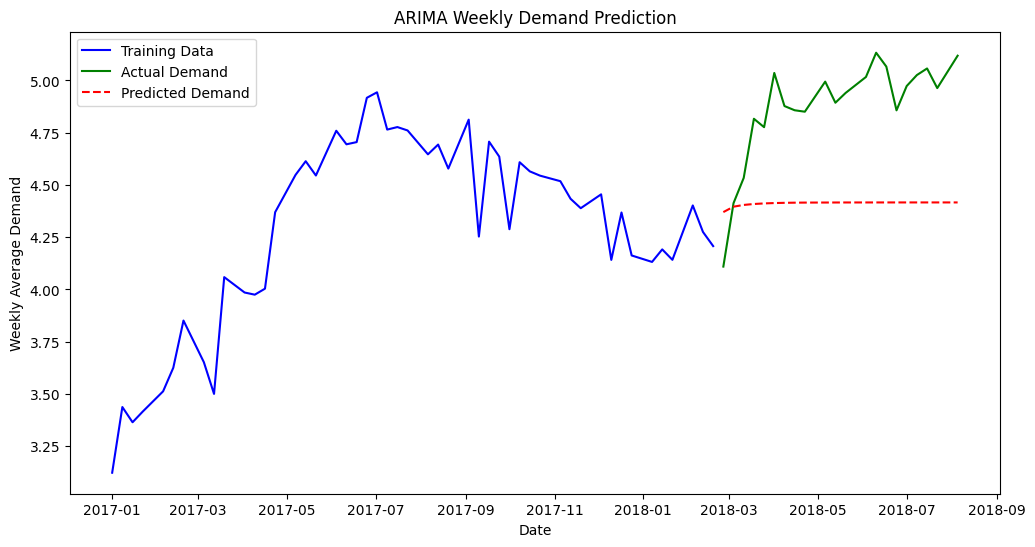

In [18]:
predict_weekly_demand(data_copy.copy())

### 5. Compare models, Which one is working better? Why? Please describe the reason.


#### Random forest regressor to predict the demand rate and report the minimum square error

In [19]:
car_sharing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8708 non-null   int64  
 1   timestamp   8708 non-null   object 
 2   season      8708 non-null   object 
 3   holiday     8708 non-null   object 
 4   workingday  8708 non-null   object 
 5   weather     8708 non-null   object 
 6   temp        8708 non-null   float64
 7   temp_feel   8708 non-null   float64
 8   humidity    8708 non-null   float64
 9   windspeed   8708 non-null   float64
 10  demand      8708 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 748.5+ KB


In [20]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          8708 non-null   int64         
 1   timestamp   8708 non-null   datetime64[ns]
 2   season      8708 non-null   object        
 3   holiday     8708 non-null   object        
 4   workingday  8708 non-null   object        
 5   weather     8708 non-null   object        
 6   temp        8708 non-null   float64       
 7   temp_feel   8708 non-null   float64       
 8   humidity    8708 non-null   float64       
 9   windspeed   8708 non-null   float64       
 10  demand      8708 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 748.5+ KB


In [21]:
car_sharing_df.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [22]:
car_sharing_df['weather'].unique()

array(['Clear or partly cloudy', 'Mist', 'Light snow or rain',
       'heavy rain/ice pellets/snow + fog'], dtype=object)

In [23]:
data_copy_regressor = data_copy.copy()

In [24]:
le = LabelEncoder()

#Categorical Features: weather, season and region
#data_copy_regressor['weather'] = le.fit_transform(data_copy_regressor['weather'])
data_copy_regressor['season'] = le.fit_transform(data_copy_regressor['season'])
data_copy_regressor['workingday'] = le.fit_transform(data_copy_regressor['workingday'])
data_copy_regressor['holiday'] = le.fit_transform(data_copy_regressor['holiday'])

data_copy_regressor = pd.get_dummies(data=data_copy_regressor, columns=['weather'], dtype=int)


data_copy_regressor['year'] = data_copy_regressor['timestamp'].dt.year
data_copy_regressor['month'] = data_copy_regressor['timestamp'].dt.month
data_copy_regressor['day'] = data_copy_regressor['timestamp'].dt.day
data_copy_regressor['hour'] = data_copy_regressor['timestamp'].dt.hour



In [25]:
data_copy_regressor.head()

,id,timestamp,season,holiday,workingday,temp,temp_feel,humidity,windspeed,demand,weather_Clear or partly cloudy,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,year,month,day,hour
0,1,2017-01-01 00:00:00,1,0,0,9.84,14.395,81.0,0.0,2.772589,1,0,0,0,2017,1,1,0
1,2,2017-01-01 01:00:00,1,0,0,9.02,13.635,80.0,0.0,3.688879,1,0,0,0,2017,1,1,1
2,3,2017-01-01 02:00:00,1,0,0,9.02,13.635,80.0,0.0,3.465736,1,0,0,0,2017,1,1,2
3,4,2017-01-01 03:00:00,1,0,0,9.84,14.395,75.0,0.0,2.564949,1,0,0,0,2017,1,1,3
4,5,2017-01-01 04:00:00,1,0,0,9.84,14.395,75.0,0.0,0.000000,1,0,0,0,2017,1,1,4


In [26]:
X = data_copy_regressor.drop(columns=['id','timestamp','demand'], axis=1)
y = data_copy_regressor.loc[:, 'demand']

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [28]:
X_train.head()

,season,holiday,workingday,temp,temp_feel,humidity,windspeed,weather_Clear or partly cloudy,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,year,month,day,hour
4003,0,0,0,21.320000,25.000,68.0,8.9981,1,0,0,0,2017,9,17,20
3193,0,0,1,32.800000,37.120,49.0,11.0014,0,0,1,0,2017,8,2,23
686,1,0,1,8.200000,11.365,64.0,6.0032,1,0,0,0,2017,2,11,22
7308,2,0,1,20.089454,29.545,78.0,8.9981,1,0,0,0,2018,5,3,21
2219,2,0,1,22.140000,25.760,88.0,6.0032,0,0,1,0,2017,5,19,9


In [29]:
print(y_train)

4003    5.170484
3193    4.882802
686     3.761200
7308    5.700444
2219    5.375278
          ...   
2940    4.762174
7321    5.293305
7753    6.001415
3300    5.583496
3578    4.127134
Name: demand, Length: 6095, dtype: float64


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_Xtrain = scaler.fit_transform(X_train)
scaled_Xval = scaler.transform(X_val)

In [31]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()

forest.fit(scaled_Xtrain, y_train)

RandomForestRegressor()

In [32]:
forestpred = forest.predict(scaled_Xval)

In [33]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, forestpred)
rmse = np.sqrt(mean_squared_error(y_test, forestpred))

In [34]:
print(mse, rmse)

0.14548526655381244 0.3814253092727493


#### Deep Neural Network to predict the demand rate and report the minimum square error

LSTM (Long Short-Term Memory) is used because it is a **recurrent neural network (RNN)** architecture specifically designed to handle **sequential and time-series data**. Here’s why LSTM is a good choice for predicting weekly average demand:

### **1. Captures Long-Term Dependencies**
   - Unlike traditional feedforward neural networks, LSTMs have **memory cells** that store important past information, allowing them to capture long-term trends and seasonal patterns in demand.

### **2. Handles Time-Series Data Better than Standard Neural Networks**
   - Standard DNNs (like fully connected layers) treat data as independent points, whereas **LSTMs consider past time steps** when making predictions.
   - This is crucial for demand forecasting, where past trends influence future values.

### **3. Prevents Vanishing Gradient Problem**
   - Traditional RNNs struggle with long sequences because of the **vanishing gradient problem**.
   - LSTM’s **gates (input, forget, output)** allow it to retain relevant information for longer periods.

### **4. Works Well for Irregular and Noisy Data**
   - Real-world demand data can have fluctuations, missing values, or seasonality. LSTMs are **robust** to such noise and can learn meaningful trends.

### **5. Outperforms ARIMA for Complex Patterns**
   - ARIMA works well for **stationary** and linear time series data.
   - LSTM can **learn non-linear relationships** and detect **complex seasonal trends** that ARIMA might miss.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def predict_weekly_demand_dnn(df, demand_col='demand', date_col='timestamp', epochs=50, batch_size=8):
    """
    Predicts the weekly average demand rate using a Deep Neural Network (LSTM model).
    Uses 70% of data for training and 30% for testing.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing timestamp and demand data.
    demand_col (str): Column name for demand values.
    date_col (str): Column name for timestamps.
    epochs (int): Number of epochs for training the neural network.
    batch_size (int): Batch size for training.
    
    Returns:
    None (Plots actual vs predicted demand).
    """
    # Make a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()
    
    # Ensure timestamp is in datetime format
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])
    df_copy.set_index(date_col, inplace=True)
    
    # Drop any NaN values
    df_copy = df_copy.dropna(subset=[demand_col])
    
    # Resample data to weekly averages
    weekly_data = df_copy[demand_col].resample('W').mean()
    
    # Fill any missing values after resampling
    weekly_data = weekly_data.fillna(method='ffill')
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    weekly_data_scaled = scaler.fit_transform(weekly_data.values.reshape(-1, 1))
    
    # Train-test split (70% train, 30% test)
    split_idx = int(len(weekly_data_scaled) * 0.7)
    train, test = weekly_data_scaled[:split_idx], weekly_data_scaled[split_idx:]
    
    # Prepare data for LSTM
    def create_sequences(data, time_steps=1):
        X, y = [], []
        for i in range(len(data) - time_steps):
            X.append(data[i:(i + time_steps), 0])
            y.append(data[i + time_steps, 0])
        return np.array(X), np.array(y)
    
    time_steps = 4  # Using past 4 weeks to predict next week
    X_train, y_train = create_sequences(train, time_steps)
    X_test, y_test = create_sequences(test, time_steps)
    
    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
        LSTM(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Predict
    predictions = model.predict(X_test)
    
    # Calculate MSE on scaled data
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Square Error (scaled): {mse:.4f}')
    
    # Convert predictions and test data back to original scale
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_actual = scaler.inverse_transform(predictions)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_data.index[split_idx + time_steps:], y_test_actual, label='Actual Demand', color='green')
    plt.plot(weekly_data.index[split_idx + time_steps:], predictions_actual, label='Predicted Demand', color='red', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Weekly Average Demand')
    plt.title('DNN (LSTM) Weekly Demand Prediction')
    plt.legend()
    plt.show()

2025-03-10 23:40:46.007284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 23:40:46.031241: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 23:40:46.273233: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 23:40:46.446866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741650046.745580  110790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741650046.82

In [36]:
data_copy.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


/tmp/ipykernel_110790/159308861.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_data = weekly_data.fillna(method='ffill')
2025-03-10 23:40:52.206129: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3591
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3585 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2258  
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1310 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━

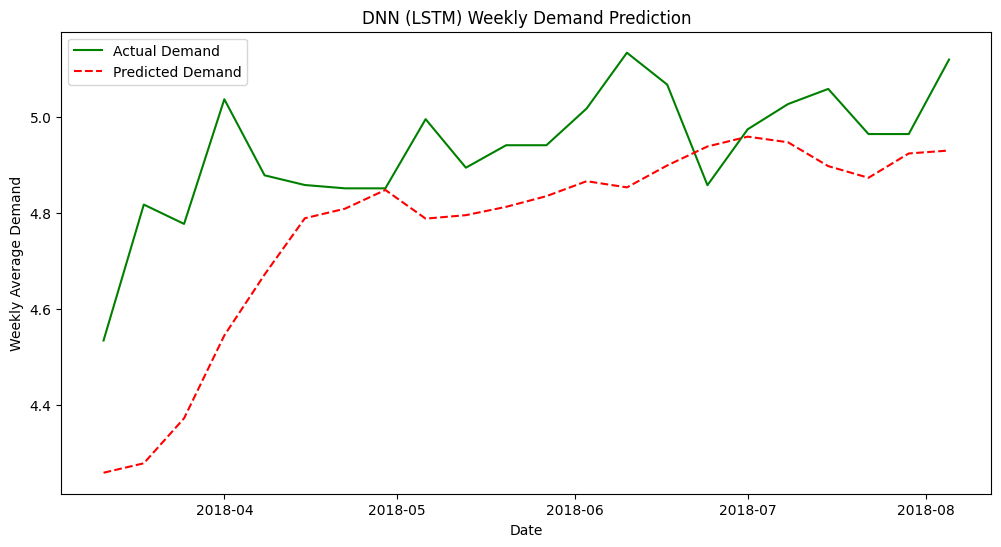

In [37]:
predict_weekly_demand_dnn(data_copy.copy(), demand_col='demand', date_col='timestamp')

### 6. CLASSIFICATION (LECTURE 12)

- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting CLassifier

In [38]:
data_copy_classifier = data_copy_regressor.copy()


# Calculate the average demand rate
average_demand_rate = data_copy_classifier['demand'].mean()
# Categorize the demand rates
data_copy_classifier['demand_category'] = data_copy_classifier['demand'].apply(lambda x: 1 if x > average_demand_rate else 2)


X = data_copy_classifier.drop(columns=['id','timestamp','demand', 'demand_category'], axis=1)
y = data_copy_classifier.loc[:, 'demand_category']


X_train, X_val, y_train, y_test = train_test_split(X, y, test_size=0.3)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [39]:
'''
# Calculate the average demand rate
average_demand_rate = df['demand'].mean()

# Categorize the demand rates
df['demand_category'] = df['demand'].apply(lambda x: 1 if x > average_demand_rate else 2)

print(df)
'''

"\n# Calculate the average demand rate\naverage_demand_rate = df['demand'].mean()\n\n# Categorize the demand rates\ndf['demand_category'] = df['demand'].apply(lambda x: 1 if x > average_demand_rate else 2)\n\nprint(df)\n"

In [40]:
X.head()

,season,holiday,workingday,temp,temp_feel,humidity,windspeed,weather_Clear or partly cloudy,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,year,month,day,hour
0,1,0,0,9.84,14.395,81.0,0.0,1,0,0,0,2017,1,1,0
1,1,0,0,9.02,13.635,80.0,0.0,1,0,0,0,2017,1,1,1
2,1,0,0,9.02,13.635,80.0,0.0,1,0,0,0,2017,1,1,2
3,1,0,0,9.84,14.395,75.0,0.0,1,0,0,0,2017,1,1,3
4,1,0,0,9.84,14.395,75.0,0.0,1,0,0,0,2017,1,1,4


In [41]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()


In [42]:
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [43]:
dtpred = dt.predict(X_val)
rfpred = rf.predict(X_val)
gbpred = gb.predict(X_val)

In [44]:
from sklearn.metrics import classification_report

print(f"\nDecision Tree: {classification_report(y_test, dtpred)}\n----------------------------------------------------")
print(f"\nForest: {classification_report(y_test, rfpred)}\n----------------------------------------------------")
print(f"\nGradient Boost: {classification_report(y_test, gbpred)}\n----------------------------------------------------")


Decision Tree:               precision    recall  f1-score   support

           1       0.93      0.93      0.93      1582
           2       0.90      0.89      0.89      1031

    accuracy                           0.92      2613
   macro avg       0.91      0.91      0.91      2613
weighted avg       0.92      0.92      0.92      2613

----------------------------------------------------

Forest:               precision    recall  f1-score   support

           1       0.92      0.95      0.94      1582
           2       0.92      0.88      0.90      1031

    accuracy                           0.92      2613
   macro avg       0.92      0.91      0.92      2613
weighted avg       0.92      0.92      0.92      2613

----------------------------------------------------

Gradient Boost:               precision    recall  f1-score   support

           1       0.93      0.95      0.94      1582
           2       0.92      0.88      0.90      1031

    accuracy                      

### 7. KMEANS (temperature data) (Lecture 10)

In [45]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
matplotlib.use('Agg')

In [46]:
car_sharing_df.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [47]:
# temp = car_sharing_df['temp']

temp = data_copy[data_copy['timestamp'].dt.year == 2017]['temp']

In [48]:
from sklearn.cluster import KMeans
from collections import Counter

# If temp is a pandas Series:
# Convert to numpy array first
temp_array = temp.values  # This converts pandas Series to numpy array

# Now reshape for KMeans
data = temp_array.reshape(-1, 1)  # Reshape to 2D for clustering

# Create x-axis values that match the length of temp
x_values = np.arange(len(temp))

k_values = [2, 3, 4, 12]

kval_cluster_diff = {}

for i in k_values:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)

    # Plot with matching array sizes
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, temp, c=kmeans.labels_, cmap='viridis')
    plt.colorbar(label='Cluster')
    plt.xlabel('Index')
    plt.ylabel('Temperature')
    plt.title('KMeans Clustering of Temperature Data')

    '''
    # Print information
    print("Temperature values:")
    print(temp)
    print("\nCluster labels:")
    print(kmeans.labels_)
    print("\nCluster centers:")
    print(kmeans.cluster_centers_)
    print("\nInertia (sum of squared distances):")
    print(kmeans.inertia_)
    '''

    # Count the number of points in each cluster
    cluster_counts = np.bincount(kmeans.labels_)
    print("Cluster sizes (K-Means):", cluster_counts)
    diff = max(cluster_counts) - min(cluster_counts)
    print("Difference between largest and smallest cluster:", diff)

    kval_cluster_diff[f'{i} k-value'] = int(diff)

    plt.savefig(f"kmeans_plot{i}.png")

Cluster sizes (K-Means): [2157 3265]
Difference between largest and smallest cluster: 1108
Cluster sizes (K-Means): [1584 2274 1564]
Difference between largest and smallest cluster: 710
Cluster sizes (K-Means): [1022 1564 2190  646]
Difference between largest and smallest cluster: 1544
Cluster sizes (K-Means): [ 660  661 1142  430  180  399  263  474  408   57  461  287]
Difference between largest and smallest cluster: 1085


In [49]:
print(kval_cluster_diff)

{'2 k-value': 1108, '3 k-value': 710, '4 k-value': 1544, '12 k-value': 1085}


**3 IS THE K WITH MOST UNIFORM CLUSTERS**


To determine which value of 𝑘 produces the most uniform clusters by observing the images, follow these steps:

1. Check Cluster Balance in the Scatter Plot:
Look at the distribution of colors in each plot. The most uniform clustering occurs when each color (cluster) has roughly the same number of points. If you notice some clusters having significantly more or fewer points, the clustering is not uniform.

For uniform clusters → The colors should be evenly distributed across the plot.
For non-uniform clusters → Some colors will dominate, while others will have very few points.

2. Compare Cluster Sizes in the Color Bar:
If your plot includes a color bar, look at how many data points correspond to each color. The more balanced the color distribution, the more uniform the clustering.

3. Count the Number of Points in Each Cluster (Best Method):
To quantify uniformity, print the number of samples in each cluster. You can do this by using np.bincount() for K-Means and np.unique() for Agglomerative Clustering.

4. Choose the Most Uniform k:

The value of 𝑘 that minimizes the difference between the largest and smallest cluster size is the most uniform.
If the difference is small, then clustering is uniform.
If the difference is large, some clusters dominate while others are underrepresented.

#### Agglomerative Hierarchical clustering Technique:
In this technique, initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until one cluster or K clusters are formed.

In [50]:
from sklearn.cluster import AgglomerativeClustering


In [51]:
k_values = [2, 3, 4, 12]
agc_kval_cluster_diff = {}

for i in k_values: 
    hierarchical_cluster = AgglomerativeClustering(n_clusters=i, metric='euclidean', linkage='ward')
    labels = hierarchical_cluster.fit_predict(data)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, temp, c=labels, cmap='viridis')
    plt.colorbar(label='Cluster')
    plt.xlabel('Index')
    plt.ylabel('Temperature')
    plt.title('Agglomerative Clustering of Temperature Data')
    plt.savefig(f"agglo_clust_plot{i}.png")


    # Count cluster sizes
    cluster_counts_agg = Counter(labels)
    print("Cluster sizes (Agglomerative Clustering):", dict(cluster_counts_agg))
    diff = max(cluster_counts) - min(cluster_counts)
    print("Difference between largest and smallest cluster:", diff)

    agc_kval_cluster_diff[f'{i} k-value'] = int(diff)

Cluster sizes (Agglomerative Clustering): {np.int64(1): 1827, np.int64(0): 3595}
Difference between largest and smallest cluster: 1085
Cluster sizes (Agglomerative Clustering): {np.int64(0): 1827, np.int64(2): 1927, np.int64(1): 1668}
Difference between largest and smallest cluster: 1085
Cluster sizes (Agglomerative Clustering): {np.int64(3): 704, np.int64(2): 1927, np.int64(1): 1123, np.int64(0): 1668}
Difference between largest and smallest cluster: 1085
Cluster sizes (Agglomerative Clustering): {np.int64(4): 482, np.int64(10): 977, np.int64(2): 508, np.int64(11): 263, np.int64(5): 352, np.int64(3): 461, np.int64(8): 222, np.int64(7): 489, np.int64(6): 581, np.int64(0): 563, np.int64(1): 370, np.int64(9): 154}
Difference between largest and smallest cluster: 1085


In [52]:
print(agc_kval_cluster_diff)

{'2 k-value': 1085, '3 k-value': 1085, '4 k-value': 1085, '12 k-value': 1085}
